# epdlib v0.5
EpdLib is a library for creating dynamically scaled screen layouts for frame-buffered devices such as e-paper/e-ink displays. Complex layouts are defined as image, drawing or text blocks. Using epdlib blocks makes it trivial to develop for different disiplay resolutions as layouts are aware of thier resolution and scale the blocks dynamically to match the available area.

## Changes
See the [ChangeLog](./changes.md) for details
### v0.5
* Add support for Block type "DrawBlock"

### v0.4
* Add support for IT8951 panels with 8bit gray scale and partial refresh
    - Assigning EPD object to screen has changed from directy assignment to using a the string that corresponds to the name.


## Dependencies
Python Modules:
* Pillow
    - System dependencies for Pillow:
        * libopenjp2-7
        * libtiff5
* RPi.GPIO
* spidev
    - ensure SPI is enabled on the pi
* waveshare-epd (Non IT8951 based panels)
    - this is for interacting with waveshare epaper displays and is not strictly needed to use the Block and Layout objects.
    - see [notes](#Notes) below for installation instructions
* IT8951 (IT8951 based panels)
    - see [notes](#Notes) below for installation instructions



**Modules:**
* [Block](#Block) - image and text blocks that can be assembed into a final layout
* [Layout](#Layout) - generate dynamic layouts from Blocks
* [Screen](#Screen) - simple interface for waking and writing to WaveShare EPD devices




<a name="Block"></a>
## Block Module
`Block` objects are containers for text and images. `Block` objects are aware of their dimensions and can be made aware of their position within a larger layout. `Block` objects can also handle wrapping text and resizing images to fit within their borders.
*Class* `Block(area, hcenter=False, vcenter=False, rand=False, inverse=False, abs_coordinates=(0, 0), padding=0)`

### Properties
        
Parent class for other types of blocks

Args [default value]: 
 *  `area`(list/tuple): x and y integer values for dimensions of block area
 *  `hcenter`(bool): True: horizontally center contents [False]
 *  `vcenter`(bool): True: vertically center contents [False]
 *  `rand`(bool): True: randomly place contents in area [False]
 *  `inverse`(bool): True: invert pixel values [False]
 *  `abs_coordinates`(list/tuple): x, y integer coordinates of this block area
    within a larger image [(0, 0)]
 *  `padding`(int): number of pixels to pad around edge of contents [0]
 *  `fill`(int): 0-255 8 bit value for fill color for text/images [0 black]
 *  `bkground`(int): 0-255 8 bit value for background color [255 white]
 *  `mode`(str): '1': 1 bit color, 'L': 8 bit grayscale ['1']

Properties:
 *  `image`: None - overridden in child classes'''

### Methods
`update(update)`
Place holder method for child classes.

## Block.DrawBlock
Child class of `Block` that contains `pillow.ImageDraw` drawing objects. `DrawBlock` objects can contain ellipses, rounded_rectangles or rectangles. These are useful for creating horizontal and vertical rules and separators. DrawBlock objects can be aligned horizontally ('center', 'left', 'right' or vertically ('center', 'top', 'bottom') within the block area.

*Class* `Block.DrawBlock(area, *args, shape=None, abs_x=None, abs_y=None, scale_x=1, scale_y=1, halign='center', valign='center', draw_format={}, no_clip=True, **kwargs)`

`DrawBlock` objects that are fully initizlized with `area` and `shape` will automatically generate an image. No further updates are necessary. When using `DrawBlock` in a `Layout` layout, it is not necessary to send an update when the block is refreshed unless the properties have been changed. The generated image will remain in memory until the program is termindated.

### Properties       
 * `area` (tuple of int): area of block in pixels
 * `shape` (str): shape to draw (see DrawBlock.list_shapes())
 * `abs_x` (int): absolute x dimension in pixels of drawing (overrides scale_x)
 * `abs_y` (int): absolute y dimension in pixels of drawing (overrides scale_y)
 * `scale_x` (float): percentage of total x area (0..1) (abs_x overrides)
 * `scale_y` (float): percentage of total y area (0..1) (abs_y overrides)
 * `halign` (str): horizontal alignment of drawing; 'center', 'left', 'right' 
 * `valign` (str): vertical alignment of drawing; 'center', 'top', 'bottom'
 * `draw_format` (dict): dict of kwargs for shape drawing function
 * `no_clip` (bool): when True fit shapes completely within area
 * `image` (PIL:Image): rendered shape
 
 ###  Methods
  * `list_shapes()`: list supported shapes that can be drawn -- Static Method
  * `draw_help()`: print help docstring for the current `shape`
  * `update(update=True)`: when `True` update the image. This is **only** necessary if the object properties have been changed or the object was not created with a `shape` value
  * `draw_image()`: update the image
  


## Block.TextBlock
Child class of `Block` that contains formatted text. `TextBlock` objects can do basic formatting of strings. Text is always rendered as a 1 bit image (black on white or white on black). Text can be horizontally justified and centered and vertically centered within the area of the block. 

All properties of the parent class are inherited.

*Class* `Block.TextBlock(font, area, text='NONE', font_size=0, max_lines=1, maxchar=None, chardist=None)`

`TextBlock` objects will attempt to calculate the appropriate number of characters to render on each line given an area, font face and character distribution. Each font face renders characters at a different width and each TTF character uses a different X width (excluding fixed-width fonts). Each language favors certain characters over others. 

### Properties
* `font` (str): path to TTF font face - relative paths are acceptable
* `area` (2-tuple of int): area of block in pixles - required
* `text` (str): string to format 
    - Default: 'NONE'
* `font_size` (int): font size in points
    - Default: 0
* `max_lines` (int): maximum number of lines to use when wrapping text
    - Default: 1
* `maxchar` (int): maximum number of characters to fit on a line
    - if set to `None`, the text block will calculate this value based on the font face and specified `chardist`
    - Default: None
* `chardist` (dict): statistical character distribution for a supported language to use for a specified font
    - dictionary of letter and float representing fractional distribution (see `print_chardist`)
* `image` (PIL.Image): resultant image generated of formatted text
*  `align` (str): 'left', 'right', 'center' justify text (default: left)

### Functions
* `print_chardist(chardist=None)` - print supported character distrubtions
    - chardist (str)
        - `chardist='USA_CHARDIST'` print the character distribution for USA English

### Methods
* `update(update=None)` - Update the text string with a new string and sets `image` property
    - update (str)

## Block.ImageBlock
Child class of `Block` that contains formated images. `ImageBlock` objects do basic formatting of color, centering and scaling. All `ImageBlock` images are 8 bit grayscale `Pillow.Image(mode='L')`. Images that are too large for the area are rescaled using the `Pillow.Image.thumbnail()` strageies to limit distortion. Images that are smaller than the set area will **not** be resized.

All properties of the parent class are inherited.

*Class* `Block.ImageBlock(area, image=None)`

### Properties
* `image` (:obj:PIL.Image or :obj:str) - `Pillow` image or path provided as a `str` to an image file; relative paths are acceptable

<a name="Layout"></a>
## Layout Module
`Layout` objects support scaling images and dynamically scaling [TTF](https://en.wikipedia.org/wiki/TrueType) font-size for different screen sizes. 

Font sizes are set based on each individual font and scaled to fit within text blocks using the maximum number of lines specified in the layout. Text is line-broken using the python [textwrap logic](https://docs.python.org/3.7/library/textwrap.html).

*Class* `Layout(resolution, layout=None, force_onebit=False)`

## Scaling Example
epdlib `Layout` objects can be scaled to any (reasonable) resolution while maintaining internally consistent ratios.

**500x500 Layout**

![500x500 weather image](./docs/weather_5x5.png)

**300x200 Layout**
![300x200 weather_image](./docs/weather_3x2.png)


### Properties
* `resolution` (2-tuple of int): resolution of the entire screen in pixles
* `layout` (dict): dictionary containing layout paramaters for each block
    - see example below in Quick-Start Recipe
* `image` (Pil.Image): concatination of all blocks into single image
* `force_onebit` (bool): force all blocks within a layout to `mode='1'`

### Methods
* `concat()`: join all blocks into a single image
    - sets `image` property
* `update_contents(updates=None)` - update the contents of each block
    - updates (dict)
        - dictionary in the format `{'text_section': 'text to use', 'image_section': '/path/to/img', 'pil_img_section': PIL.Image}`

<a name="Screen"></a>
## Screen Module
`Screen` objects provide a method for waking and writing to a WaveShare E-Paper Display (EPD). `Screen` objects are aware of their resolution and when they were last updated (stored in monotonic time). 

*Class* `Screen(resolution=None, epd=None)`

### Properties
* `resolution` (2 tuple of int): resolution in pixels 
    - this is overriden by the epd object resolution when it is set
* `epd` (epd object)
    - waveshare epd object used for interfacing with the display
* `update` (obj:Screen.Update): monotonicly aware object that tracks time since last update
* `rotation` (int): [-90, 0, 90, 180, 270] rotation of screen 
* `mode`(str): '1' for 1 bit screens, 'L' for screens capable of 8 bit grayscale
* `vcom`(float): vcom voltage for HD IT8951 based screens (not needed & ignored for non-HD screens)


### Methods
* `clearScreen()`: Set a blank image screen
* `clearEPD()`: send the clear signal to the EPD to wipe all contents and set to "white"
* `writeEPD(image, sleep=True, partial=False)`: write `image` to the EPD. 
    - resets update timer
    - sleep: put the display to low power mode (default: True)
    - partial: update only chaged portions of the screen (faster, but only works with black and white pixles) (default: False)
* `intiEPD()` - initializes the EPD for writing
* `blank_image():` produces a blank PIL.Image in of `mode` type of `resolution` dimensions
* `list_compatible_modules()`: print a list of all waveshare_epd panels that are compatible with paperpi

### Example
```
import Screen
import waveshare_epd
myScreen = Screen()
myScreen.epd = "epd5in83"
myScreen.initEPD()
myScreen.writeEPD('./my_image.png')
```


## Screen.Update
Create a monotonically aware object that records the passage of time.

*Class* `Screen.Update()`

### Properties
* `age` (float): age in seconds since creation
* `now` (float): time in [CLOCK_MONOTONIC](https://linux.die.net/man/3/clock_gettime) time
* `last_updated` (float): time in seconds since last updated
* `update` (bool): True - trigger resets last_updated time

### Methods
* `update(update=True)` - reset last_updated timer to zero

### Example
```
import Screen
u = Update()
u.now
>>> 357147.118559987
u.age
>>> 37.449310125026386
u.last_updated
>>> 62.2587232599617
u.update = True
u.last_updated
>>> 0.00021347898291423917
```

## Screen.ScreenShot
Capture a rolling set of screenshots. When the total number of screenshots exceeds `n` the oldest is deleted. Images are stored as .png.

This is useful for debugging over time.

*Class* `Screen.ScreenShot(path='./', n=2, prefix=None)`

### Properties
* `total` (int): total number of screenshots to keep
* `prefix` (str): prefix to add to filenames
* `time` (str): time in format: %y-%m-%d_%H%M.%S - 2020-02-29_1456.39
* `img_array` (list): list of files stored in `path`

### Methods
* `delete(img)`: delete `img` file
* `save(img)`: save `img` to `path`
    - img: PIL.Image
```
import Screen
scrnShot = Screen.ScreenShot(path='/temp/', n=20)
spam = PIL.Image.new(mode='L', size=(100, 100), color=0)
scrnShot.save(spam)
```

## Quick-Start Recipes
### Quick Demo
The demo creates a very basic layout and displays some text in four orientations. This is an easy way to test your panel and confirm that it is working properly.

`python3 -m epdlib.Screen`

### Creating an Image from a Layout
The following recipe will produce the screen layout shown above for a 640x400 pixel display. This image can be passed directly to a WaveShare e-Paper display for writing.

```
import epdlib

# create the layout object - adjust the resolution to match the display area
layout_obj = epdlib.Layout(resolution=(640, 400))

l = { # basic two row layout
    'tux_img': {                
            'type': 'ImageBlock',        # required as of v0.6
            'image': True,               # image block
            'padding': 10,               # pixels to padd around edge
            'width': .25,                # 1/4 of the entire width
            'height': 1/4,               # 1/4 of the entire height
            'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
            'hcenter': True,             # horizontally center image
            'vcenter': True,             # vertically center image
            'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
            'mode': 'L',                 # treat this image as an 8bit gray-scale image
        },
    'vertical_rule_1' :{
            'type': 'DrawBlock',         # required as of v0.6
            'shape': 'rounded_rectangle',# shape to draw
            'abs_x': 5,                  # absolute x dimension of shape in pixels
            'scale_y': .8,               # scale shape so it is 80% of available area
            'halign': 'center',          # horizontally center in area
            'valign': 'center',          # vertically center in area
            'draw_format': {'radius': 5, # any key word args (kwargs) needed for formatting the shpae
                            'outline': 128,
                            'width': 2},
            'height': 1/4,
            'width': .02,
            'abs_coordinates': (None, 0), # x value will be calculated from the 'tux_image' block, the y value is "0"
            'relative': ['tux_img', 'vertical_rule_1'] # use 'tux_image' X value, use 'vertical_rule_1' for Y value
    },
    'pangram_a': { 
            'type': 'TextBlock',          # required as ov v0.6
            'image': None,                # set to None if this is a text block
            'max_lines': 3,               # maximum lines of text to use when wrapping text
            'padding': 10,                # padding around all edges (in pixles)
            'width': .73,                 # proportion of the entire width
            'height': 1/4,                # proprtion of the entire height
            'abs_coordinates': (None, 0), # absolute coordinates within the final image (use None for those
                                          # coordinates that are relative to other blocks and will be calculated
            'hcenter': False,             # horizontal-center the text and the resulting image
            'vcenter': True,              # vertically-center the text within the block
            'relative': ['vertical_rule_1', 'pangram_a'], # blocks to which THIS block's coordinates are relative to
                                                        # -- in this case X: `weather_img` and Y: `temperature`
                                                        # the width of the block `weather` will be used to
                                                        # to calculate the X value of this block and the Y value
                                                        # specified within the `temperature` block will be used 
            'font': './fonts/Open_Sans/OpenSans-Regular.ttf', # TTF Font face to use; relative paths are OK
            'font_size': None,             # set this to None to automatically scale the font to the size of the block
            'mode': 'L'                    # set text blocks to "mode": L" to enable anti-aliasing on HD screens (automatically disabled on non HD)
    },
    'pangram_b': { 
                'type': 'TextBlock',
                'image': None,
                'max_lines': 2,
                'padding': 0,
                'width': 1,
                'height': 1/4,
                'abs_coordinates': (0, None),
                'hcenter': True,
                'vcenter': True,
                'relative': ['pangram_b', 'tux_img'],
                'font': './fonts/Open_Sans/OpenSans-Regular.ttf',
                'font_size': None,
                'inverse': True,
                'mode': 'L'
    },
    'pangram_c': {
                'type': 'TextBlock',
                'image': None,
                'max_lines': 2,
                'padding': 0,
                'width': 1,
                'height': 1/4,
                'abs_coordinates': (0, None),
                'hcenter': True,
                'vcenter': False,
                'relative': ['pangram_c', 'pangram_b'],
                'font': './fonts/Open_Sans/OpenSans-BoldItalic.ttf',
                'font_size': None,
                'inverse': False,
                'mode': 'L'
    },    
    'text': {
                'type': 'TextBlock',
                'image': None,
                'max_lines': 3,
                'padding': 10,
                'width': 1,
                'height': 1/4,
                'abs_coordinates': (0, None),
                'hcenter': False,
                'vcenter': True,
                'relative': ['text', 'pangram_c'],
                'font': './fonts/Open_Sans/OpenSans-Regular.ttf',
                'font_size': None,
                'inverse': True
    }

}

# apply the layout instructions to the layout object
layout_obj.layout = l

# create a dictionary with the values that will be pushed to each block
# note that is is not necessary to update the DrawBlocks if they are fully configured
update = {
    'tux_img': './images/tux.png',      
    'pangram_a': 'The quick brown fox jumps over the lazy dog.',  
    'pangram_b': 'Pack my box with five jugs of liquor.',          
    'pangram_c': 'Jackdaws love my big sphinx of quartz.',                    
    'text': 'A pangram or holoalphabetic sentence is a sentence using every letter of a given alphabet at least once. This text is not anti-aliased'}


# update the layout with the data in the dictionary and send each item to the proper block
layout_obj.update_contents(update)

# join all the sub images into one complete image
myImg = layout_obj.concat()
# write the image out to a file
myImg.save('sample.jpg')

```

### Write an image to a Screen
The following code will create an interface for writing images to the EPD
*Requirements*
* Waveshare EPD module or IT8951 library (see Notes below)

```
from epdlib import Screen
from PIL import Image
## non IT8951 screens
my_epd = "epd2in7" 
my_vcom = None
## IT8951 screens
# my_epd = "HD"
# my_vcom = -1.8

# create screen object
my_screen = Screen(epd=my_epd, vcom=my_vcom)

my_resolution = my_screen.resolution

# open image, convert to 1 bit and scale
my_img = Image.open('path/to/image.jpg')
my_img = my_img.convert("1")
my_img.thumbail(my_resolution)

# write image to screen
my_screen.writeEPD(my_img)

# clear screen
my_screen.clearEPD()
```

<a name="Notes"></a>
## Notes
**WaveShare non-IT8951 Screens**
The waveshare-epd library is required for non-IT8951 screens and can be installed from the Git repo:
```
pip install -e "git+https://github.com/waveshare/e-Paper.git#egg=waveshare_epd&subdirectory=RaspberryPi_JetsonNano/python"
```

**IT8951 basee Screens**
The Broadcom BCM 2835 library is required by the IT8951 module. Download and install the BCM2835 library according to the directions found on [Mike McCauley's site](http://www.airspayce.com/mikem/bcm2835/)

[Greg D Meyer's IT8951 library](https://github.com/GregDMeyer/IT8951) is also required and can be installed from the Git repo:
```
pip install -e "git+https://github.com/GregDMeyer/IT8951#egg=IT8951"
```

DEBUG:root:checking default values for layout
DEBUG:root:section: [-----------tux_img------------]
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-------vertical_rule_1--------]
DEBUG:root:adding "no_clip: True"
DEBUG:root:adding "image: None"
DEBUG:root:adding "hcenter: False"
DEBUG:root:adding "vcenter: False"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "mode: 1"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [----------pangram_a-----------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [----------pangram_b-----------]
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "fill: 0"
DEBUG:root:a

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DEBUG:root:calculated font size: 19
DEBUG:root:calculating block position from relative positions
DEBUG:root:block coordinates: (0, 300)
INFO:root:setting blocks
INFO:root:section: [___________tux_img____________]
DEBUG:root:setting block type: ImageBlock
DEBUG:root:block area: (160, 100)
DEBUG:root:padded area: [140, 80]
DEBUG:root:fill: 0, bkground: 255
DEBUG:root:creating Block
DEBUG:root:no image set; setting to blank image with area: (160, 100)
INFO:root:section: [_______vertical_rule_1________]
DEBUG:root:setting block type: DrawBlock
DEBUG:root:block area: (13, 100)
DEBUG:root:padded area: [13, 100]
DEBUG:root:fill: 0, bkground: 255
DEBUG:root:creating Block
DEBUG:root:setting fill to: 0
DEBUG:root:drawing image
DEBUG:root:using absolute pixel size 0: 5
DEBUG:root:using calculated pixel size 1: 80
DEBUG:root:pixel_size: [5, 80]
DEBUG:root:alignment: h=center, v=center
INFO:root:no_clip: forcing shape inside bounds of area if necessary
DEBUG:root:box coordinates: [4, 10, 9, 90]
D

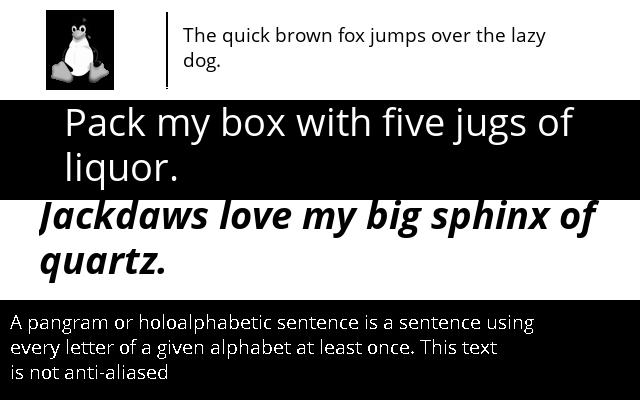

In [12]:
# %load_ext autoreload
# %autoreload 2

# %reload_ext autoreload
# import epdlib

# # create the layout object - adjust the resolution to match the display area
# layout_obj = epdlib.Layout(resolution=(640, 400))

# l = { # basic two row layout
#     'tux_img': {                
#             'type': 'ImageBlock',        # required as of v0.6
#             'image': True,               # image block
#             'padding': 10,               # pixels to padd around edge
#             'width': .25,                # 1/4 of the entire width
#             'height': 1/4,               # 1/4 of the entire height
#             'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
#             'hcenter': True,             # horizontally center image
#             'vcenter': True,             # vertically center image
#             'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
#             'mode': 'L',                 # treat this image as an 8bit gray-scale image
#         },
#     'vertical_rule_1' :{
#             'type': 'DrawBlock',         # required as of v0.6
#             'shape': 'rounded_rectangle',# shape to draw
#             'abs_x': 5,                  # absolute x dimension of shape in pixels
#             'scale_y': .8,               # scale shape so it is 80% of available area
#             'halign': 'center',          # horizontally center in area
#             'valign': 'center',          # vertically center in area
#             'draw_format': {'radius': 5, # any key word args (kwargs) needed for formatting the shpae
#                             'outline': 128,
#                             'width': 2},
#             'height': 1/4,
#             'width': .02,
#             'abs_coordinates': (None, 0), # x value will be calculated from the 'tux_image' block, the y value is "0"
#             'relative': ['tux_img', 'vertical_rule_1'] # use 'tux_image' X value, use 'vertical_rule_1' for Y value
#     },
#     'pangram_a': { 
#             'type': 'TextBlock',          # required as ov v0.6
#             'image': None,                # set to None if this is a text block
#             'max_lines': 3,               # maximum lines of text to use when wrapping text
#             'padding': 10,                # padding around all edges (in pixles)
#             'width': .73,                 # proportion of the entire width
#             'height': 1/4,                # proprtion of the entire height
#             'abs_coordinates': (None, 0), # absolute coordinates within the final image (use None for those
#                                           # coordinates that are relative to other blocks and will be calculated
#             'hcenter': False,             # horizontal-center the text and the resulting image
#             'vcenter': True,              # vertically-center the text within the block
#             'relative': ['vertical_rule_1', 'pangram_a'], # blocks to which THIS block's coordinates are relative to
#                                                         # -- in this case X: `weather_img` and Y: `temperature`
#                                                         # the width of the block `weather` will be used to
#                                                         # to calculate the X value of this block and the Y value
#                                                         # specified within the `temperature` block will be used 
#             'font': './fonts/Open_Sans/OpenSans-Regular.ttf', # TTF Font face to use; relative paths are OK
#             'font_size': None,             # set this to None to automatically scale the font to the size of the block
#             'mode': 'L'                    # set text blocks to "mode": L" to enable anti-aliasing on HD screens (automatically disabled on non HD)
#     },
#     'pangram_b': { 
#                 'type': 'TextBlock',
#                 'image': None,
#                 'max_lines': 2,
#                 'padding': 0,
#                 'width': 1,
#                 'height': 1/4,
#                 'abs_coordinates': (0, None),
#                 'hcenter': True,
#                 'vcenter': True,
#                 'relative': ['pangram_b', 'tux_img'],
#                 'font': './fonts/Open_Sans/OpenSans-Regular.ttf',
#                 'font_size': None,
#                 'inverse': True,
#                 'mode': 'L'
#     },
#     'pangram_c': {
#                 'type': 'TextBlock',
#                 'image': None,
#                 'max_lines': 2,
#                 'padding': 0,
#                 'width': 1,
#                 'height': 1/4,
#                 'abs_coordinates': (0, None),
#                 'hcenter': True,
#                 'vcenter': False,
#                 'relative': ['pangram_c', 'pangram_b'],
#                 'font': './fonts/Open_Sans/OpenSans-BoldItalic.ttf',
#                 'font_size': None,
#                 'inverse': False,
#                 'mode': 'L'
#     },    
#     'text': {
#                 'type': 'TextBlock',
#                 'image': None,
#                 'max_lines': 3,
#                 'padding': 10,
#                 'width': 1,
#                 'height': 1/4,
#                 'abs_coordinates': (0, None),
#                 'hcenter': False,
#                 'vcenter': True,
#                 'relative': ['text', 'pangram_c'],
#                 'font': './fonts/Open_Sans/OpenSans-Regular.ttf',
#                 'font_size': None,
#                 'inverse': True
#     }

# }

# # apply the layout instructions to the layout object
# layout_obj.layout = l

# # create a dictionary with the values that will be pushed to each block
# # note that is is not necessary to update the DrawBlocks if they are fully configured
# update = {
#     'tux_img': './images/tux.png',      
#     'pangram_a': 'The quick brown fox jumps over the lazy dog.',  
#     'pangram_b': 'Pack my box with five jugs of liquor.',          
#     'pangram_c': 'Jackdaws love my big sphinx of quartz.',                    
#     'text': 'A pangram or holoalphabetic sentence is a sentence using every letter of a given alphabet at least once. This text is not anti-aliased'}


# # update the layout with the data in the dictionary and send each item to the proper block
# layout_obj.update_contents(update)

# # join all the sub images into one complete image
# myImg = layout_obj.concat()
# # write the image out to a file
# myImg.save('sample.jpg')

getting ready for pypi:
https://medium.com/@joel.barmettler/how-to-upload-your-python-package-to-pypi-65edc5fe9c56

In [13]:
!jupyter-nbconvert --to markdown --template md_nocode README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 19138 bytes to README.md
